# Anomaly detection in multiclass label classification
#### Authors:
### Maria Musiał 156062
### Martyna Stasiak 156071
------------------------------------

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%.

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction (showing which part of which series is responsible for a defect)
 - Neural network with at least one recurrent layer must be used in each step
 - Not the whole logic must be inside the neural network
 - Your approach should work for other data, of course after retraining. It means you shouldn't take advantage of knowing the series are based on sin function and how the anomalies are created.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Masking, Lambda, Conv1D, RepeatVector, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from sklearn.metrics import accuracy_score



## Generating the data

In [3]:
np.random.seed(42)

In [4]:
n = 50000

In [5]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [6]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)


In [7]:
# for i in range(5):
#     plt.plot(xl[i])
#     print(yl[i])
#     plt.show()

---------------------------------------------
## This problem is a multiclass label classification.  
Each instance can belong to multiple classes at once, which translates to the fact that each candy can have zero up to multiple defects.<br>
We apply Long Short Term Memory network, as its best suited in this case. <br>
The outputs (defects) are converted to multi-hot encoded labels for better processing and computing.<br>

The data is padded, as we have different lenghts sequences. Then, in the network our first layer is Masking, so that we don't learn from the zeroes. 
- binary corssentropy applied to each output (class)
- sigmoid function for wach class
- output with multiple dimentions

Loss:
- hamming losss (compare set of predicted labels to set of actual labels)
- loss: 
CategoricalCrossentropy

Metrics: 
- Hamming Loss: Measures the average proportion of labels that were incorrectly predicted.
- F1 Score: Provides a balance between Precision and Recall.
- Jaccard Index: Measures the similarity between predicted and actual labels.
- Subset Accuracy: Measures the percentage of labels that are exactly correct.
Precision, Recall, F1 Score, Hamming Loss, Subset Accuracy, and AUC-ROC

Consider: 
- normalization
- randomsearch hyperparameter tuning
- ensemble methods? stacking rnns? [if too much time lol]

### Padding and masking! for diffferent lenghts of variables

- garnki: https://www.youtube.com/watch?v=jyphzUamJrQ

In [8]:
# Convert to multi-hot encoded labels
num_classes = len(yl[0])

def true_false_to_multi_hot(labels, num_classes):
    encoded_labels = []
    for label in labels:
        multi_hot_label = [1 if x else 0 for x in label]
        encoded_labels.append(multi_hot_label)
    return np.array(encoded_labels)


multi_hot_labels = true_false_to_multi_hot(yl, num_classes)
# print(multi_hot_labels)

## Checking class distribution 
<span style="font-size: 20px;">to get to know if we need some class weights to help model learn by providing more equal distribution. As it turns out, the classes are distributed equally, so there is no class imbalance. Meaning that no calculation of class weights is needed, as model should already be learning classes at approximately the same rate.</span>

In [9]:
# getting to know class weights cause of minority labels ??
class_distribution = np.sum(multi_hot_labels, axis=0)
print(f"class distrib: {class_distribution}")


class distrib: [12584 12390 12537 12652 12542]


## He Normal initializer 
<span style="font-size: 22px;">draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2/fan_in), where fan_in is the number of input units in the weight tensor.
<br>It is the best initializer in case of using ReLU as activation functions, as we do in our architecture. 
<br> this initialization improves convergence. Without it, first 20 epochs our model didn't learn.

In [10]:
from keras.initializers import HeNormal

initializer = HeNormal()



In [11]:
# Padding because of varying sequence lengths
sequence_lengths = [len(seq) for seq in xl]
max_len = max(sequence_lengths)
padded_sequences = pad_sequences(xl, maxlen=max_len, padding='post', dtype='float32')  #post means that the padding is added after the sequence

In [12]:
#Min-Max scaling
scaler = MinMaxScaler(feature_range=(0, 1))
padded_sequences = scaler.fit_transform(padded_sequences.reshape(-1, 3)).reshape(-1, padded_sequences.shape[1], 3)

In [13]:
#split data 80-20
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, multi_hot_labels, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42  # 0.25 x 0.8 = 0.2 of the total dataset
)

In [14]:
# Define the model with a Masking layer to not train on the padded parts. 
model = Sequential([
    Masking(mask_value=0, input_shape=(max_len, 3)),
    LSTM(64, kernel_initializer = initializer),
    # LSTM(32),
    Dense(5, activation='sigmoid')  # Multi-label classification for 5 potential anomalies
])

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 59, 3)             0         
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 17733 (69.27 KB)
Trainable params: 17733 (69.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# # Compile the model
# model.compile(optimizer=Adam(), 
#               loss='binary_crossentropy',  # Use categorical crossentropy for multi-label classification
#               metrics=['accuracy'])  # Hamming Loss, Subset Accuracy dont work #mse #binary accuracy 

# # , Precision(), Recall(), AUC()

# #Early stopping
# callbacks = EarlyStopping(monitor="loss", patience=15, restore_best_weights= True)

# # Fiting the model
# history = model.fit(
#     # X_train[:1000], y_train[:1000],
#     X_train, y_train,
#     epochs=120,
#     batch_size=32,
#     validation_data=(X_val, y_val),  # Use test set for validation during training
#     callbacks = [callbacks]
# )

# model.save("model_candy_weights.keras")
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [16]:
model = load_model("model_candy_weights.keras")
with open('history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

In [17]:
#plotting training, validation loss from history

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>

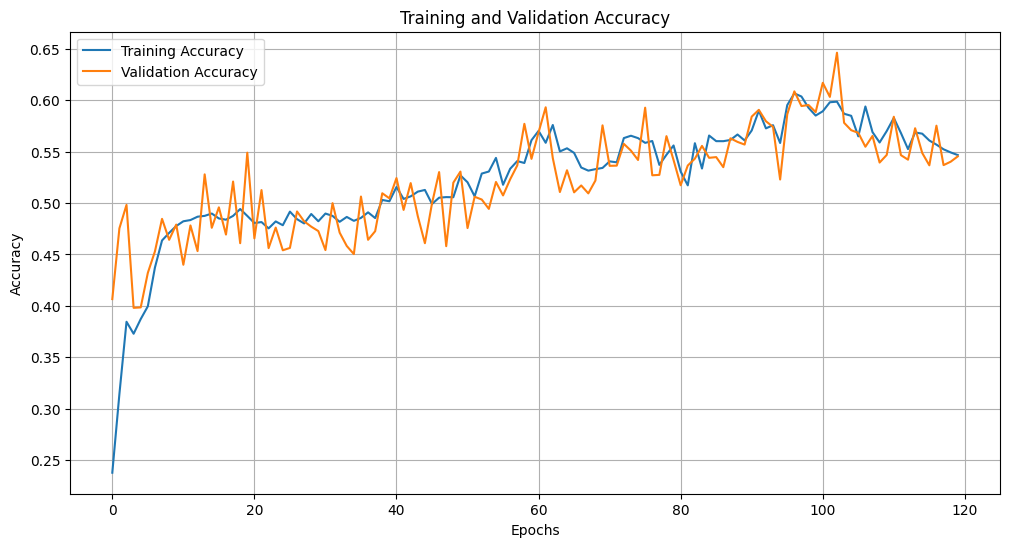

In [13]:
#plotting training, validation accuracy from history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
# Evaluating the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")   #those values mean nothing.


5000/5000 [==============================] - 33s 6ms/step - loss: 0.0050 - accuracy: 0.5439
Test Loss: 0.005009673070162535
Test Accuracy: 0.5439000129699707


### Checking accuracy by thresholding the predictions on 0.5

In [19]:
# Predict on the test set
test_predictions = model.predict(X_test)

# Apply thresholding for binary results
threshold = 0.5
binary_test_predictions = (test_predictions > threshold).astype(int)


accuracy = accuracy_score(y_test, binary_test_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


313/313 [==============================] - 5s 11ms/step
Accuracy: 99.37%


In [21]:
#Creating df with predictions and real values to check if the predictions really match up. It seems so.
comparison_df = pd.DataFrame({
    'Factual': [list(row) for row in y_test],
    'Predicted': [list(row) for row in binary_test_predictions]
})
comparison_df  

,Factual,Predicted
0,"[0, 0, 1, 0, 0]","[0, 0, 1, 0, 0]"
1,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
2,"[0, 0, 1, 0, 1]","[0, 0, 1, 0, 1]"
3,"[0, 1, 1, 1, 0]","[0, 1, 1, 1, 0]"
4,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
...,...,...
9995,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]"
9996,"[0, 1, 1, 0, 1]","[0, 1, 1, 0, 1]"
9997,"[1, 0, 0, 0, 1]","[1, 0, 0, 0, 1]"
9998,"[1, 0, 1, 0, 1]","[1, 0, 1, 0, 1]"


# Hyperparameter optimization
We are going to test:
- number of LSTM layers 1-3.
- Number of LSTM units: 32, 64, 128, 256
- Dropout rate: 0.1-0.5 every 0.1 step
- Batch size: 16, 32, 64
- Learning rate: 1e-4, 1e-3, 1e-2
<!-- - Optimizer: Adam, RMSprop, SGD -->

In [17]:
# import tensorflow as tf
# from keras.models import Sequential
# from keras.layers import Masking, LSTM, Dense, Dropout
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping
# from kerastuner import HyperModel
# from kerastuner.tuners import RandomSearch

# # Define HyperModel for Tuning
# class AnomalyDetectionHyperModel(HyperModel):
#     def build(self, hp):
#         model = Sequential()
#         model.add(Masking(mask_value=0, input_shape=(max_len, 3)))
        
#         # Add LSTM layers
#         for i in range(hp.Int('num_lstm_layers', 1, 3)):
#             model.add(LSTM(units=hp.Choice(f'lstm_units_{i}', [32, 64, 128]), 
#                            return_sequences=(i < hp.Int('num_lstm_layers', 1, 3) - 1)))
#             model.add(Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

#         # Add Dense output layer
#         # model.add(Dense(5, activation=hp.Choice('activation', ['sigmoid', 'relu'])))
#         model.add(Dense(5, activation='sigmoid'))
        
#         # Compile the model
#         model.compile(
#             optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-4, 1e-3, 1e-2])),
#             loss='binary_crossentropy',
#             metrics=['accuracy']
#         )
#         return model

# # Initialize tuner
# tuner = RandomSearch(
#     AnomalyDetectionHyperModel(),
#     objective='val_accuracy',
#     max_trials=20,  # Number of models to test
#     executions_per_trial=2,  # Number of times to train each model for robustness
#     directory='tuner_logs',
#     project_name='anomaly_detection_optimization'
# )

# X_subset, _, y_subset, _ = train_test_split(
#     X_train, y_train, test_size=0.8, stratify=y_train, random_state=42
# )

# # Perform hyperparameter search
# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# tuner.search(
#     X_subset, y_subset,
#     epochs=80,
#     batch_size=16,
#     validation_data=(X_val, y_val),
#     callbacks=[early_stopping]
# )


# # Get the best model
# best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
# best_model = tuner.get_best_models(1)[0]

# # Save the best model
# best_model.save("optimized_model_candy.keras")

# # Print best hyperparameters
# print("Best Hyperparameters:")
# print(best_hyperparameters.values)


Trial 1 Complete [00h 07m 05s]
val_accuracy: 0.49379999935626984

Best val_accuracy So Far: 0.49379999935626984
Total elapsed time: 00h 07m 05s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_lstm_layers
128               |32                |lstm_units_0
0.2               |0.2               |dropout_rate
0.01              |0.001             |learning_rate

Epoch 1/80
375/375 [==============================] - 20s 46ms/step - loss: 0.5702 - accuracy: 0.2040 - val_loss: 0.5663 - val_accuracy: 0.1818
Epoch 2/80
375/375 [==============================] - 15s 41ms/step - loss: 0.5661 - accuracy: 0.2155 - val_loss: 0.5656 - val_accuracy: 0.0808
Epoch 3/80
375/375 [==============================] - 16s 42ms/step - loss: 0.5650 - accuracy: 0.2010 - val_loss: 0.5647 - val_accuracy: 0.1818
Epoch 4/80
375/375 [==============================] - 15s 41ms/step - loss: 0.5650 - accuracy: 0.1970 - val_loss: 0.5634 - val_accuracy

KeyboardInterrupt: 

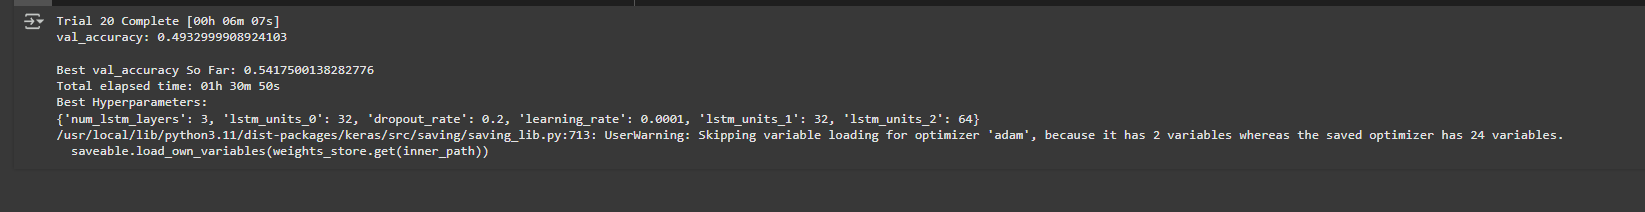

pozytywne przyklady, negatywne przyklady i czemu tak jest, analiza 

# Explainability


## 1. Check with seasonal from statsmodel, but it doesnt give good results

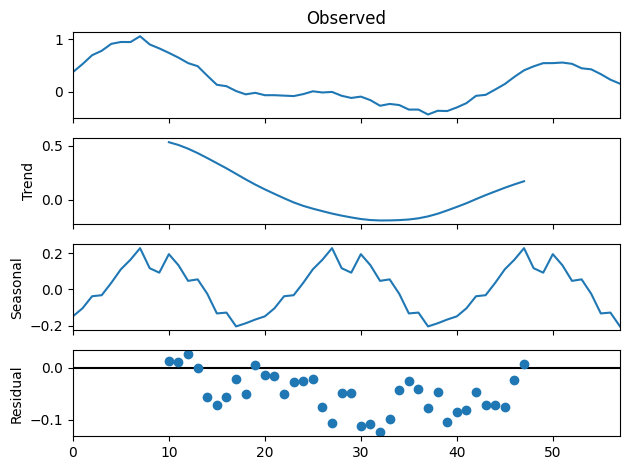

Residual anomalies for series 0:
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.01293998  0.00964406
  0.02576449 -0.00016063 -0.05581772 -0.07278515 -0.05717185 -0.02195804
 -0.05135752  0.00490744 -0.01374028 -0.01695575 -0.05160071 -0.02746578
 -0.02653773 -0.02231092 -0.07500975 -0.10603419 -0.04938161 -0.04938161
 -0.1117032  -0.10840728 -0.12452771 -0.09860259 -0.04294551 -0.02597807
 -0.04159137 -0.07680519 -0.0474057  -0.10367066 -0.08502294 -0.08180747
 -0.04716251 -0.07129744 -0.07222549 -0.07645231 -0.02375348  0.00727096
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan]


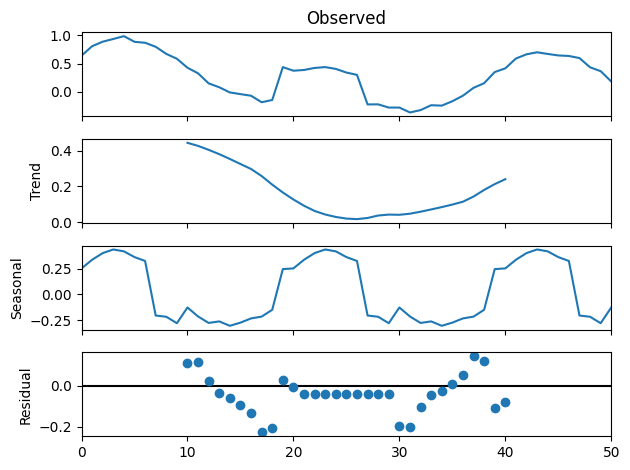

Residual anomalies for series 1:
[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.1093213   0.11495
  0.02130853 -0.0377231  -0.05985938 -0.09250047 -0.13410455 -0.22714188
 -0.20583487  0.02522075 -0.00619729 -0.04212095 -0.04212095 -0.04212095
 -0.04212095 -0.04212095 -0.04212095 -0.04212095 -0.04212095 -0.04212095
 -0.19356321 -0.1991919  -0.10555043 -0.0465188  -0.02438252  0.00825856
  0.04986264  0.14289998  0.12159296 -0.10946266 -0.07804461         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan]


In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

for i, (x,y) in enumerate(zip(xl[:2], yl[:2])):
    if any(str(val).lower() == "true" for val in y):
        row_flat = x.mean(axis=1)  
        # Flatten row into a 1D array for decomposition
        result = seasonal_decompose(row_flat, model='additive', period=20)  # Adjust period as needed
        
        # Plot decomposition
        result.plot()
        plt.show()

        # Analyze residuals
        residuals = result.resid
        print(f"Residual anomalies for series {i}:")
        print(residuals)


## Other options

In [22]:
# explain = Sequential([
#     Masking(mask_value=0, input_shape=(max_len, 3)),
#     LSTM(32, return_sequences=True),
#     Dense(5, activation='sigmoid')  # Multi-label classification for 5 potential anomalies
# ])

In [25]:
# from keras.metrics import MeanSquaredError

# # Create the RNN model (LSTM example)
# explain = Sequential()
# explain.add(LSTM(50, activation='relu', input_shape=(X_train[0].shape[0], X_train[0].shape[1])))
# explain.add(Dense(5, activation='sigmoid'))

# explain.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanSquaredError()])
# explain.summary()

# # Train the model
# explain.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# # Predictions and anomaly detection
# y_pred = explain.predict(X_test)

# # Calculate error (you can use MSE or any other error metric)
# errors = np.array([np.mean(np.abs(y_test[i] - y_pred[i])) for i in range(len(y_test))])

# # Thresholding to detect anomalies
# threshold = np.percentile(errors, 95)  # Choose threshold based on performance

# anomalies = [errors[i] > threshold for i in range(len(errors))]

# # Explainability: Feature importances using SHAP
# # import shap
# # explainer = shap.Explainer(model, x_test)
# # shap_values = explainer(x_test)
# # shap.initjs()
# # shap.summary_plot(shap_values, x_test)

In [26]:
# print(y_pred)

# Attention

autoencoder na danych bez defektu <br>
-ktora czesc dal ktorego defektu dokladnie 

In [28]:
from keras.models import Model
from keras.layers import LSTM, Dense, Attention

## This gives only attention for last series of points.

# Example of LSTM with Attention
inputs = Input(shape=(X_train[0].shape[0], X_train[0].shape[1]))
masked_input = Masking(mask_value=0)(inputs)
lstm = LSTM(50, return_sequences=False, kernel_initializer = initializer)(masked_input)
attention = Attention()([lstm, lstm])
#### max albo nowa warstwa ktora zmienia wymiar 
output = Dense(5, activation='sigmoid')(attention)

atten = Model(inputs, output)
atten.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
atten.summary()

# Training the model
atten.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

# Attention visualization
attention_layer = Model(inputs=[atten.input], outputs=[atten.get_layer('attention').output])
attention_weights = attention_layer.predict(X_test)

# Example to visualize attention
import matplotlib.pyplot as plt
for i in range(len(X_test)):
    plt.figure(figsize=(12, 4))
    plt.title(f"Attention Heatmap for Sample {i}")
    plt.imshow(attention_weights[i], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Input Time Steps')
    plt.ylabel('Attention Weight')
    plt.show()


c:\Users\mary9\anaconda3\envs\cv_lab\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 59, 3)]              0         []                            
                                                                                                  
 masking_2 (Masking)         (None, 59, 3)                0         ['input_2[0][0]']             
                                                                                                  
 lstm_3 (LSTM)               (None, 50)                   10800     ['masking_2[0][0]']           
                                                                                                  
 attention_1 (Attention)     (None, 50)                   0         ['lstm_3[0][0]',              
                                                                     'lstm_3[0][0]']        

KeyboardInterrupt: 

In [ ]:
# model.add(Attention(name='attention'))

# #Visualising it later
# attention_layer = Model(inputs=[model.input], outputs=[model.get_layer('attention').output])
# attention_weights = attention_layer.predict(x_test)

# # Example to visualize attention
# import matplotlib.pyplot as plt
# for i in range(len(x_test)):
#     plt.figure(figsize=(12, 4))
#     plt.title(f"Attention Heatmap for Sample {i}")
#     plt.imshow(attention_weights[i], aspect='auto', cmap='viridis')
#     plt.colorbar()
#     plt.xlabel('Input Time Steps')
#     plt.ylabel('Attention Weight')
#     plt.show()


In [38]:
autoenc = Sequential(
      [
       Input(shape=(max_len, 3)),
       Conv1D(filters=32, kernel_size = 15, padding = 'same', data_format= 'channels_last',
                     dilation_rate = 1, activation = 'linear'),
       LSTM(units = 25, activation = 'tanh', name = 'LSTM_layer_1',return_sequences= False),
       RepeatVector(max_len),
       LSTM(units = 25, activation = 'tanh', name = 'LSTM_layer_2', return_sequences= True),
       Conv1D(filters = 32, kernel_size = 15, padding = 'same', data_format = 'channels_last',
                     dilation_rate = 1, activation = 'linear'),
       TimeDistributed(Dense(1, activation = 'linear'))
      ]
  )

autoenc.compile(optimizer=Adam(learning_rate = 0.001), loss = "mse")
autoenc.summary()


history = autoenc.fit(
    X_train,
    X_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", 
                                              patience=25, 
                                              mode="min", 
                                              restore_best_weights=True)])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 59, 32)            1472      
                                                                 
 LSTM_layer_1 (LSTM)         (None, 25)                5800      
                                                                 
 repeat_vector_3 (RepeatVec  (None, 59, 25)            0         
 tor)                                                            
                                                                 
 LSTM_layer_2 (LSTM)         (None, 59, 25)            5100      
                                                                 
 conv1d_8 (Conv1D)           (None, 59, 32)            12032     
                                                                 
 time_distributed_2 (TimeDi  (None, 59, 1)             33        
 stributed)                                           